```{index} single: AMPL; AMPL Python API
```
```{index} bilinear constraints
```
```{index} McCormick envelopes
```
```{index} single: solver; cbc
```
```{index} single: solver; couenne
```
# Milk pooling and blending

Pooling and blending operations involve the "pooling" of various streams to create intermediate mixtures that are subsequently blended with other streams to meet final product specifications. These operations are common to the chemical processing and petroleum sectors where limited tankage may be available, or when it is necessary to transport materials by train, truck, or pipeline to remote blending terminals. Similar applications arise in agriculture, food, mining, wastewater treatment, and other industries.

This notebook considers a simple example of a wholesale milk distributor to show how **non-convexity** arises in the optimization of pooling and blending operations. Non-convexity is due to presence of **bilinear** terms that are the product of two decision variables where one is a scale-dependent **extensive** quantity measuring the amount or flow of a product, and the other is scale-independent **intensive** quantity such as product composition. The notebook then shows how to develop and solve a convex approximation of the problem, and finally demonstrates solution the use of [Couenne](https://github.com/coin-or/Couenne), a solver specifically designed to find global solutions to mixed integer nonlinear optimization (MINLO) problems.

In [1]:
# install dependencies and select solver
%pip install -q amplpy pandas matplotlib numpy scipy

SOLVER_LO = "cbc"
SOLVER_GNLO = "couenne"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["coin"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

## Problem: Pooling milk for wholesale blending and distribution

A bulk distributor supplies custom blends of milk to several customers. Each customer has specified a minimum fat content, a maximum price, and a maximum amount for the milk they wish to buy. The distributor sources raw milk from local farms. Each farm produces a milk with a known fat content and cost. 

The distributor has recently identified more affordable sources raw milk from several distant farms. These distant farms produce milk grades that can be blend with milk from the local farms. However, the distributor only has one truck with a single tank available for transporting milk from the distant farms. As a result, milk from the distant farms must be combined in the tank before being transported to the blending station. This creates a "pool" of uniform composition which to be blended with local milk to meet customer requirements.

The process is shown in the following diagram. The fat content and cost of raw milk is given for each farm. For each customer, data is given for the required milk fat content, price, and the maximum demand. The arrows indicate pooling and blending of raw milk supplies. Each arrow is labeled with the an amount of raw milk.

![](milk-pooling.png)

What should the distributor do?

* Option 1. Do nothing. Continue operating the business as usual with local suppliers.

* Option 2. Buy a second truck to transport raw milk from the remote farms to the blending facility without pooling.

* Option 3. Pool raw milk from the remote farms into a single truck for transport to the blending facility.


In [2]:
customers = pd.DataFrame(
    {
        "Customer 1": {"min_fat": 0.045, "price": 52.0, "demand": 6000.0},
        "Customer 2": {"min_fat": 0.030, "price": 48.0, "demand": 2500.0},
        "Customer 3": {"min_fat": 0.040, "price": 50.0, "demand": 4000.0},
    }
).T

suppliers = pd.DataFrame(
    {
        "Farm A": {"fat": 0.045, "cost": 45.0, "location": "local"},
        "Farm B": {"fat": 0.030, "cost": 42.0, "location": "local"},
        "Farm C": {"fat": 0.033, "cost": 37.0, "location": "remote"},
        "Farm D": {"fat": 0.050, "cost": 45.0, "location": "remote"},
    },
).T

local_suppliers = suppliers[suppliers["location"] == "local"]
remote_suppliers = suppliers[suppliers["location"] == "remote"]

print("\nCustomers")
display(customers)

print("\nSuppliers")
display(suppliers)


Customers


,min_fat,price,demand
Customer 1,0.045,52.0,6000.0
Customer 2,0.030,48.0,2500.0
Customer 3,0.040,50.0,4000.0



Suppliers


,fat,cost,location
Farm A,0.045,45.0,local
Farm B,0.03,42.0,local
Farm C,0.033,37.0,remote
Farm D,0.05,45.0,remote


## Option 1. Business as usual

The normal business of the milk distributor is to blend supplies from local farms to meet customer requirements. Let $L$ designate the set of local suppliers, and let $C$ designate the set of customers. Decision variable $z_{l, c}$ is the amount of milk from local supplier $l\in L$ that is mixed into the blend sold to customer $c\in C$.

The distributor's objectives is to maximize profit

$$
\begin{align*}
\text{profit} & = \sum_{(l, c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l) z_{l,c}
\end{align*}
$$ 

where $(l, c)\ \in\ L\times C$ indicates a summation over the cross-product of two sets. Each term, $(\text{price}_c - \text{cost}_l)$, is the net profit of including one unit of raw milk from supplier $l\in L$ in the blend delivered to customer $c\in C$.

The amount of milk delivered to each customer $c\in C$ can not exceed the customer demand.

$$
\begin{align*}
\sum_{l\in L} z_{l, c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

Let $\text{fat}_l$ denote the fat content of the raw milke produced by farm $l$, and let  $\text{min_fat}_c$ denote the minimum fat content required by customer $c$, respectively. Assuming linear blending, the model becomes

$$
\begin{align*}
\sum_{(l,c)\ \in\ L \times C} \text{fat}_{l} z_{l,c} & \geq \text{min_fat}_{c} \sum_{l\in L} z_{l, c} & \forall c \in C
\end{align*}
$$

This is a standard linear blending problem that can be solved by linear optimization (LO).

In [3]:
model = AMPL()
model.eval(
    """
    # define sources and customers
    set L;
    set C;

    param price{C};
    param demand{C};
    param min_fat{C};
    param cost{L};
    param fat{L};

    # define local -> customer flowrates
    var z{L cross C} >= 0;

    maximize profit: sum{l in L, c in C} z[l, c]*(price[c] - cost[l]);

    subject to demand_req{c in C}:
        sum{l in L} z[l, c] <= demand[c];

    subject to fat_content{c in C}:
        sum{l in L} z[l, c] * fat[l] >= sum{l in L} z[l, c] * min_fat[c];
"""
)

model.set_data(customers, "C")
model.set_data(local_suppliers.drop(columns=["location"]), "L")

model.option["solver"] = SOLVER_LO
model.get_output("solve;")

# report results
print(f"\nProfit = {model.obj['profit'].value():0.2f}\n")

# create dataframe of results
z = model.var["z"]
L = model.set["L"]
C = model.set["C"]

print("Blending Plan")
Z = pd.DataFrame(
    [[l, c, round(z[l, c].value(), 1)] for l in L.members() for c in C.members()],
    columns=["supplier", "customer", ""],
)
Z = Z.pivot_table(index="customer", columns="supplier")
Z["Total"] = Z.sum(axis=1)
Z["fat content"] = [
    sum(z[l, c].value() * suppliers.loc[l, "fat"] for l in L.members())
    / sum(z[l, c].value() for l in L.members())
    for c in C.members()
]
Z["min_fat"] = customers["min_fat"]

display(Z)


Profit = 81000.00

Blending Plan


Total fat content min_fat
supplier    Farm A  Farm B                            
customer                                              
Customer 1  6000.0     0.0  6000.0       0.045   0.045
Customer 2     0.0  2500.0  2500.0       0.030   0.030
Customer 3  2666.7  1333.3  4000.0       0.040   0.040

## Option 2. Buy an additional truck

The distributor can earn a profit of 81,000 using only local suppliers. Is is possible earn a higher profit by also sourcing raw milk from the remote suppliers?

Before considering pooling, the distributor may wish to know the maximum profit possible if raw milk from the remote suppliers could be blended just like local suppliers. This would require acquiring and operating a separate transport truck for each remote supplier, and is worth knowing if the additional profit would justify the additional expense.

The linear optimization model presented Option 1 extends the to include both local and remote suppliers. 

In [4]:
model = AMPL()
model.eval(
    """
    # define sources and customers
    set S;
    set C;

    param price{C};
    param demand{C};
    param min_fat{C};
    param cost{S};
    param fat{S};

    # define local -> customer flowrates
    var z{S cross C} >= 0;

    maximize profit: sum{s in S, c in C} z[s, c]*(price[c] - cost[s]);

    subject to demand_req{c in C}:
        sum{s in S} z[s, c] <= demand[c];

    subject to quality{c in C}:
        sum{s in S} z[s, c] * fat[s] >= sum{s in S} z[s, c] * min_fat[c];
"""
)

model.set_data(customers, "C")
model.set_data(suppliers.drop(columns=["location"]), "S")

model.option["solver"] = SOLVER_LO
model.get_output("solve;")

# report results
print(f"\nProfit = {model.obj['profit'].value():0.2f}\n")

# create dataframe of results
z = model.var["z"]
S = model.set["S"]
C = model.set["C"]

print("Blending Plan")
Z = pd.DataFrame(
    [[s, c, round(z[s, c].value(), 1)] for s in S.members() for c in C.members()],
    columns=["supplier", "customer", ""],
)
Z = Z.pivot_table(index="customer", columns="supplier")
Z["Total"] = Z.sum(axis=1)
Z["fat content"] = [
    sum(z[s, c].value() * suppliers.loc[s, "fat"] for s in S.members())
    / sum(z[s, c].value() for s in S.members())
    for c in C.members()
]
Z["min_fat"] = customers["min_fat"]

display(Z)


Profit = 122441.18

Blending Plan


Total fat content min_fat
supplier   Farm A Farm B  Farm C  Farm D                            
customer                                                            
Customer 1    0.0    0.0  1764.7  4235.3  6000.0       0.045   0.045
Customer 2    0.0    0.0  2500.0     0.0  2500.0       0.033   0.030
Customer 3    0.0    0.0  2352.9  1647.1  4000.0       0.040   0.040

Sourcing raw milk from the remote farms significantly increases profits. This blending, however, requires at least two trucks to keep the sources of milk from the remote suppliers separated until they reach the blending facility. Note that the local suppliers are completely replaced by the lower cost remote suppliers, even to the extent of providing "product giveaway" by surpassing the minimum requirements of Customer 2.

## Option 3. Pool delivery from remote suppliers

Comparing Option 1 with Option 2 shows there is significantly more profit to be earned by purchasing raw milk from the remote suppliers. But that option requires an additional truck to keep the supplies separated during transport. 

Because only one truck with a single tank is available for transport from the remote farms, the pool and blending problem is to combine purchases from the remote suppliers into a single pool of uniform composition, transport that pool to the distribution facility, then blend with raw milk from local suppliers to meet individual customer requirements. Compared to option 2, the profit potential may be reduced due to pooling, but without the need to acquire an additional truck.

### Pooling problem

There are a several mathematical formulations of pooling problem in the academic literature. The formulation used here is called the "p-parameterization" where the pool composition represents a new decision variable $p$. The other additional decision variables are $x_r$ referring to the amount of raw milk purchased from remote supplier $r\in R$, and $y_c$ which is the amount of the pooled milk included in the blend delivered to customer $c\in C$.

The profit objective is the difference between the income received for selling blended products and the cost of purchasing raw milk from local and remote suppliers.

$$
\begin{align*}
\text{Profit} & = \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l)\ z_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r x_{r}
\end{align*}
$$

The product delivered to each customer from local farms and the pool can not exceed demand.

$$
\begin{align*}
\sum_{l\in L} z_{l, c} + y_{c} & \leq \text{demand}_{c} & \forall c\in C
\end{align*}
$$

Purchases from the remote farms and the amounts delivered to customers from the pool must balance.

$$
\begin{align*}
\sum_{r\in R}x_{r} & = \sum_{c\in C} y_{c} \\
\end{align*}
$$

The average milk fat composition of the pool, $p$, must satisfy an overall balance on milk fat entering the pool from the remote farms and the milk fat delivered to customers.

$$
\begin{align*}
\sum_{r\in R}\text{fat}_{r}\ x_{r}  & = \underbrace{p \sum_{c\in C} y_{c}}_{\text{bilinear}}
\end{align*}
$$

Finally, the milk fat required by each customer $c\in C$ satisfies a blending constraint.

$$
\begin{align*}
\underbrace{p y_{c}}_{\text{bilinear}}  + \sum_{(l,c)\ \in\ L \times C} \text{fat}_{l}\ z_{l,c}
& \geq \text{min_fat}_{c}\ (\sum_{l\in L} z_{l, c} + y_{c})
& \forall c \in C
\end{align*}
$$

The last two constraints include **bilinear** terms which are the product of the decision variable $p$ with decision variables $y_c$ for all $c\in C$. 

Summarizing, the **blending and pooling problem** is to find a solution to maximize profit, where

$$
\begin{align*}
\max\ \text{Profit} = & \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l)\ z_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r x_{r} \\
\text{s.t.}\qquad & \sum_{l\in L} z_{l, c} + y_{c} \leq \text{demand}_{c} & \forall c\in C \\
& \sum_{r\in R}x_{r} = \sum_{c\in C} y_{c} \\
& \underbrace{p y_{c}}_{\text{bilinear}}  + \sum_{(l,c)\ \in\ L \times C} \text{fat}_{l}\ z_{l,c} \geq \text{min_fat}_{c}\ (\sum_{l\in L} z_{l, c} + y_{c}) & \forall c \in C \\
& \sum_{r\in R}\text{fat}_{r}\ x_{r} = \underbrace{p \sum_{c\in C} y_{c}}_{\text{bilinear}} \\
& p, x_r, y_c, z_{l, c} \geq 0 & \forall r\in R, c\in C, l\in L 
\end{align*}
$$

Before attempting a solution to this problem, let's first consider the implications of the bilinear terms.

### Why are bilinear problems hard?

Bilinearity has a profound consequence on the nature of the optimization problem. To demonstrate this point, we consider a function obtained by fixing $p$ in the milk pooling problem and solving the resulting linear optimization problem for the maximum profit $f(p)$.

In [5]:
model_p_fixed = AMPL()
model_p_fixed.eval(
    """
  # define sources
  set L;
  set R;

  # define customers
  set C;

  # define flowrates
  var x{R} >= 0;
  var y{C} >= 0;
  var z{L cross C} >= 0;

  param p >= 0;
  param price{C};
  param demand{C};
  param min_fat{C};
  param cost{L union R};
  param fat{L union R};

  maximize profit: sum{l in L, c in C} z[l, c]*(price[c] - cost[l])
                    + sum{c in C} price[c]*y[c]
                    - sum{r in R} cost[r]*x[r];

  subject to customer_demand{c in C}:
      y[c] + sum{l in L} z[l, c] <= demand[c];

  subject to pool_balance:
    sum{r in R} x[r] = sum{c in C} y[c];

  subject to pool_quality:
    sum{r in R} fat[r]*x[r] = p*sum{c in C} y[c];

  subject to customer_quality{c in C}:
      p*y[c] + sum{l in L} fat[l]*z[l,c] >= min_fat[c]*(sum{l in L} z[l, c] + y[c]);
"""
)

model_p_fixed.set_data(customers, "C")
model_p_fixed.set_data(local_suppliers.drop(columns=["location"]), "L")
model_p_fixed.set_data(remote_suppliers.drop(columns=["location"]), "R")

model_p_fixed.option["solver"] = SOLVER_LO


# solve milk pooling problem for a fixed pool composition p
def f(p):
    model_p_fixed.param["p"] = p
    model_p_fixed.get_output("solve;")
    return model_p_fixed

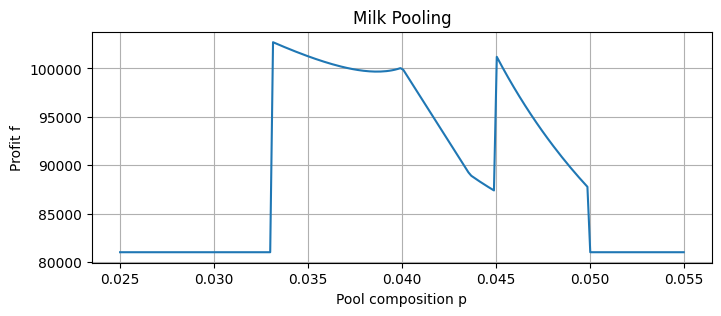

In [6]:
p_plot = np.linspace(0.025, 0.055, 200)
f_plot = [f(p).obj["profit"].value() for p in p_plot]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(p_plot, f_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit f")
ax.grid(True)
plt.show()

In contrast to linear or other convex optimization problems, the objective function for this **bilinear optimization problem is a non-convex function of a decision variable** $p$ denoting the composition of the blending pool. In fact, when profit is plotted as a function of $p$, there are three local maxima separated by two local minima. 

### Convex Approximation

The cause of the non-convexity in milk pooling problem are thee bilinear terms $p y_c$ for all $c\in C$ that appear in the constraints. A linear approximation can be obtained by introducing decision variables $w_c$ to take the place of the bilinear terms $p y_c$ in the model expressions. The result is a new, but incomplete, linear optimization problem

$$
\begin{align*}
\max\ \text{Profit} = & \sum_{(l,c)\ \in\ L \times C} (\text{price}_c - \text{cost}_l)\ z_{l,c}
+ \sum_{c\in C} \text{price}_c y_{c} - \sum_{r\in R} \text{cost}_r x_{r} \\
\text{s.t.}\qquad & \sum_{l\in L} z_{l, c} + y_{c} \leq \text{demand}_{c} & \forall c\in C \\
& \sum_{r\in R}x_{r} = \sum_{c\in C} y_{c} \\
& w_c + \sum_{(l,c)\ \in\ L \times C} \text{fat}_{l}\ z_{l,c} \geq \text{min_fat}_{c}\ (\sum_{l\in L} z_{l, c} + y_{c}) & \forall c \in C \\
& \sum_{r\in R}\text{fat}_{r}\ x_{r} = \underbrace{p \sum_{c\in C} y_{c}}_{\text{bilinear}} \\
& w_c, x_r, y_c, z_{l, c} \geq 0 & \forall r\in R, c\in C, l\in L 
\end{align*}
$$

Just adding additional variables isn't enough. Also needed are constraints that cause $w_c$ to have close to or equal to $p y_c$, that is $w_c \approx p y_c$ for all $c\in C$. If so, then this process produces a convex approximation to the original problem. Because the approximation relaxes the original constraints, a solution to the convex approximation will produced an over-estimate the potential profit.

From the problem formulation, the values of $y_c$ are bounded between 0 and demand of customer $c$, and the value of $p$ is bounded between the minimum and maximum milk fat concentrations of the remote farms.

$$
\begin{align*}
0 \leq\ & y_c \leq \text{demand}_c\ & \forall c\in C \\
\min_{r\in R} \text{conc}_r \leq\ & p \leq \max_{r\in R} \text{conc}_r \\
\end{align*}
$$

Representing the bounds on $p$ and $y_c$ as 

$$
\begin{align*}
\underline{p} & \leq p \leq \bar{p} \\
\underline{y}_c & \leq y_c \leq \bar{y}_c & \forall c\in C 
\end{align*}
$$

the McCormick envelope on $w_c$ is given by a system of four inequalities. For each $c\in C$,

$$
\begin{align*}
w_c & \geq \underline{y}_c p + \underline{p} y_c - \underline{p}\underline{y}_c \\
w_c & \geq \bar{y}_c p + \bar{p} y_c - \bar{p}\bar{y}_c \\
w_c & \leq \bar{y}_c p + \underline{p} y_c - \bar{p}\underline{y}_c \\
w_c & \leq \underline{y}_c p + \bar{p} y_c - \underline{p}\bar{y}_c \\
\end{align*}
$$

The features to note are:

* Use of a rule to specify bounds on the decision variables `y[c]`.
* Creating a new decision variable `p` with bounds.
* Creating a new set of decision variables `w[c]` to replace the bilinear terms.
* Using McCormick envelopes for variables `w[c]`.

The result of these operations is a linear model that will provide an upper bound on the profit. Hopefully the resulting solution and bound will be a close enough approximation to be useful.

In [7]:
def milk_pooling_convex():
    m = AMPL()
    m.eval(
        """
    # define sources
    set L;
    set R;

    # define customers
    set C;

    param price{C};
    param demand{C};
    param min_fat{C};
    param cost{L union R};
    param fat{L union R} default 0;

    # define flowrates
    var x{R} >= 0;
    var y{c in C} >= 0 <= demand[c];
    var z{L cross C} >= 0;
    # composition of the pool
    var p >= min{r in R} fat[r] <= max{r in R} fat[r];

    # w[c] to replace bilinear terms p * y[c]
    var w{C} >= 0;

    maximize profit: sum{l in L, c in C} z[l, c]*(price[c] - cost[l])
                      + sum{c in C} price[c]*y[c]
                      - sum{r in R} cost[r]*x[r];

    subject to customer_demand{c in C}:
        y[c] + sum{l in L} z[l, c] <= demand[c];

    subject to pool_balance:
      sum{r in R} x[r] = sum{c in C} y[c];

    subject to pool_quality:
      sum{r in R} fat[r]*x[r] = sum{c in C} w[c];

    subject to customer_quality{c in C}:
        w[c] + sum{l in L} fat[l]*z[l,c] >= min_fat[c]*(sum{l in L} z[l, c] + y[c]);

    subject to
      mccormick_ll{c in C}: w[c] >= y[c].lb0*p + p.lb0*y[c] - p.lb0*y[c].lb0;
      mccormick_hh{c in C}: w[c] >= y[c].ub0*p + p.ub0*y[c] - p.ub0*y[c].ub0;
      mccormick_lh{c in C}: w[c] <= y[c].ub0*p + p.lb0*y[c] - p.lb0*y[c].ub0;
      mccormick_hl{c in C}: w[c] <= y[c].lb0*p + p.ub0*y[c] - p.ub0*y[c].lb0;
  """
    )

    m.set_data(customers, "C")
    m.set_data(local_suppliers.drop(columns=["location"]), "L")
    m.set_data(remote_suppliers.drop(columns=["location"]), "R")

    m.option["solver"] = SOLVER_LO
    m.get_output("solve;")
    return m

In [8]:
def report_solution(m, model_title):
    x = m.var["x"]
    y = m.var["y"]
    z = m.var["z"]
    if model_title == "Milk Pooling Model":
        p = m.param["p"]
    else:
        p = m.var["p"]
    L = m.set["L"]
    R = m.set["R"]
    C_model = m.set["C"]

    # Supplier report
    S = suppliers.copy()
    for l in L.members():
        for c in C_model.members():
            S.loc[l, c] = z[l, c].value()
    for r in R.members():
        S.loc[r, "Pool"] = x[r].value()
    S = S.fillna(0)
    S["Amount"] = S[C_model.members()].sum(axis=1) + S["Pool"]
    S["Expense"] = S["Amount"] * S["cost"]

    # Customer report
    C = customers.copy()
    for c in C_model.members():
        for l in L.members():
            C.loc[c, l] = z[l, c].value()
    for c in C_model.members():
        C.loc[c, "Pool"] = y[c].value()
    C = C.fillna(0)
    C["Amount"] = C[L.members()].sum(axis=1) + C["Pool"]
    C["fat delivered"] = (
        sum(C[l] * S.loc[l, "fat"] for l in L.members()) + C["Pool"] * p.value()
    ) / C["Amount"]
    C["Income"] = C["Amount"] * C["price"]

    print(model_title)
    print(f"\nPool composition = {p.value():0.2f}")
    print(f"Profit = {m.obj['profit'].value():0.2f}")
    print(f"\nSupplier Report\n")
    display(S.round(4))
    print(f"\nCustomer Report\n")
    display(C.round(4))


m_convex = milk_pooling_convex()

report_solution(m_convex, "Milk Pooling Model - Convex Approximation")

Milk Pooling Model - Convex Approximation

Pool composition = 0.04
Profit = 111411.76

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,2500.0,0.0000,0.0,0.0000,2500.0000,112500.0000
Farm B,0.030,42.0,local,0.0,1029.4118,0.0,0.0000,1029.4118,43235.2941
Farm C,0.033,37.0,remote,0.0,0.0000,0.0,4852.9412,4852.9412,179558.8235
Farm D,0.050,45.0,remote,0.0,0.0000,0.0,4117.6471,4117.6471,185294.1176



Customer Report



,min_fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,2500.0,0.0000,3500.0000,6000.0,0.0421,312000.0
Customer 2,0.030,48.0,2500.0,0.0,1029.4118,1470.5882,2500.0,0.0359,120000.0
Customer 3,0.040,50.0,4000.0,0.0,0.0000,4000.0000,4000.0,0.0400,200000.0


The convex approximation of the milk pooling model estimates an upper bound on profit of 111,412 for a pool composition $p = 0.040$. The plot below compares this solution to what was found by in an exhaustive search over values of $p$.

Text(0.036, 106000, 'convex approximation')

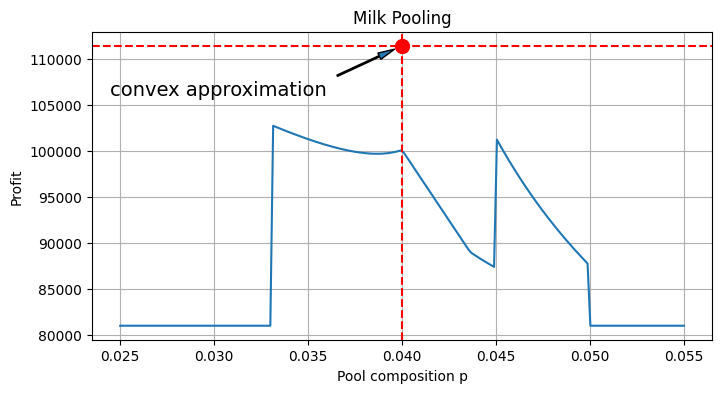

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p_plot, f_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(m_convex.var["p"].value(), m_convex.obj["profit"].value(), "ro", ms=10)
ax.axhline(m_convex.obj["profit"].value(), color="r", linestyle="--")
ax.axvline(m_convex.var["p"].value(), color="r", linestyle="--")
ax.annotate(
    "convex approximation",
    xy=(m_convex.var["p"].value(), m_convex.obj["profit"].value()),
    xytext=(0.036, 106000),
    ha="right",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)

As this stage the calculations find the maximum profit for a given value of $p$. The challenge, of course, is that the optimal value of $p$ is unknown. The following cell computes profits over a range of $p$.

The convex approximation is clearly misses the market in the estimate of profit and pool composition $p$. Without the benefit of the full scan of profit as a function of $p$, the only check on the profit estimate would be to compute the solution to model for the reported value of $p$. This is done below.

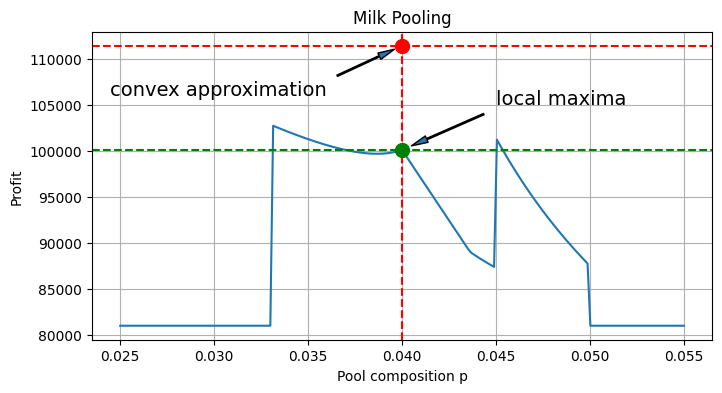

In [10]:
p = m_convex.var["p"].value()
m_convex_profit = m_convex.obj["profit"].value()

m_est = f(p)
m_est_profit = m_est.obj["profit"].value()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p_plot, f_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(p, m_convex_profit, "ro", ms=10)
ax.axhline(m_convex_profit, color="r", linestyle="--")
ax.axvline(p, color="r", linestyle="--")
ax.annotate(
    "convex approximation",
    xy=(p, m_convex_profit),
    xytext=(0.036, 106000),
    ha="right",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)

ax.plot(p, m_est_profit, "go", ms=10)
ax.axhline(m_est_profit, color="g", linestyle="--")
ax.annotate(
    "local maxima",
    xy=(p, m_est_profit),
    xytext=(0.045, 105000),
    ha="left",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)
plt.show()

The result shows the profit if the pooled milk transported from the remote farms has a fat content $p = 0.04$ them a profit of 100,088 is realized which is better than 81,000 earned for business as usual with just local suppliers, but falls short of the 122,441 earned if the remote milk supply could be transported without pooling.

The following cell presents a full report of the solution.

In [11]:
report_solution(m_est, "Milk Pooling Model")

Milk Pooling Model

Pool composition = 0.04
Profit = 100088.24

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,6000.0,0.0,0.0,0.0000,6000.0000,270000.0000
Farm B,0.030,42.0,local,0.0,0.0,0.0,0.0000,0.0000,0.0000
Farm C,0.033,37.0,remote,0.0,0.0,0.0,3823.5294,3823.5294,141470.5882
Farm D,0.050,45.0,remote,0.0,0.0,0.0,2676.4706,2676.4706,120441.1765



Customer Report



,min_fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,6000.0,0.0,0.0,6000.0,0.045,312000.0
Customer 2,0.030,48.0,2500.0,0.0,0.0,2500.0,2500.0,0.040,120000.0
Customer 3,0.040,50.0,4000.0,0.0,0.0,4000.0,4000.0,0.040,200000.0


With regard to the practical impact, the results of using this particular convex approximation are mixed. The approximation successfully produced a value for the pool composition $p$ which would produce a profit of over 100,088. However, the reported value for $p$ was actually the smallest of the three local maxima for this problem. This discrepancy may have large consequences regarding the choice of suppliers.

## Global Nonlinear Optimization (GNLO) solution with Couenne

The final version of this milk pooling model returns to the bilinear formulation with pool composition $p$ as a decision variable. The following AMPL implementation needs to specify a solver capable of solving the resulting problem. This has been tested with nonlinear solvers [`ipopt`](https://github.com/coin-or/Ipopt) and [`couenne`](https://github.com/coin-or/Couenne). [Pre-compiled binaries for these solvers can be downloaded from AMPL](https://ampl.com/products/solvers/open-source/). 

In [12]:
def milk_pooling_bilinear():
    m = AMPL()
    m.eval(
        """
    # define sources
    set L;
    set R;

    # define customers
    set C;

    param price{C};
    param demand{C};
    param min_fat{C};
    param cost{L union R};
    param fat{L union R};

    # define flowrates
    var x{R} >= 0;
    var y{C} >= 0;
    var z{L cross C} >= 0;
    # composition of the pool
    var p >= min{r in R} fat[r] <= max{r in R} fat[r];

    maximize profit: sum{l in L, c in C} z[l, c]*(price[c] - cost[l])
                      + sum{c in C} price[c]*y[c]
                      - sum{r in R} cost[r]*x[r];

    subject to customer_demand{c in C}:
        y[c] + sum{l in L} z[l, c] <= demand[c];

    subject to pool_balance:
      sum{r in R} x[r] = sum{c in C} y[c];

    subject to pool_quality:
      sum{r in R} fat[r]*x[r] = p*sum{c in C} y[c];

    subject to customer_quality{c in C}:
        p*y[c] + sum{l in L} fat[l]*z[l,c] >= min_fat[c]*(sum{l in L} z[l, c] + y[c]);
  """
    )

    m.set_data(customers, "C")
    m.set_data(local_suppliers.drop(columns=["location"]), "L")
    m.set_data(remote_suppliers.drop(columns=["location"]), "R")

    m.option["solver"] = SOLVER_GNLO
    m.get_output("solve;")
    return m

Milk Pooling Model - Bilinear

Pool composition = 0.03
Profit = 102833.33

Supplier Report



,fat,cost,location,Customer 1,Customer 2,Customer 3,Pool,Amount,Expense
Farm A,0.045,45.0,local,6000.0,0.0,2333.3333,0.0000,8333.3333,375000.0000
Farm B,0.030,42.0,local,0.0,0.0,0.0000,0.0000,0.0000,0.0000
Farm C,0.033,37.0,remote,0.0,0.0,0.0000,4166.6667,4166.6667,154166.6667
Farm D,0.050,45.0,remote,0.0,0.0,0.0000,-0.0000,-0.0000,-0.0000



Customer Report



,min_fat,price,demand,Farm A,Farm B,Pool,Amount,fat delivered,Income
Customer 1,0.045,52.0,6000.0,6000.0000,0.0,0.0000,6000.0,0.045,312000.0
Customer 2,0.030,48.0,2500.0,0.0000,0.0,2500.0000,2500.0,0.033,120000.0
Customer 3,0.040,50.0,4000.0,2333.3333,0.0,1666.6667,4000.0,0.040,200000.0


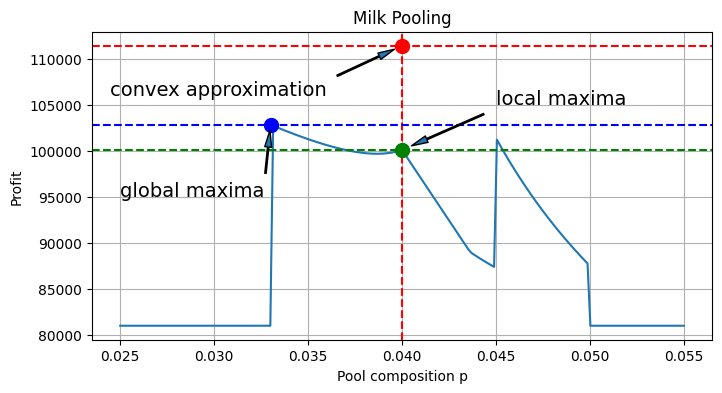

In [13]:
m_global = milk_pooling_bilinear()

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p_plot, f_plot)
ax.set_title("Milk Pooling")
ax.set_xlabel("Pool composition p")
ax.set_ylabel("Profit")
ax.grid(True)

ax.plot(p, m_convex_profit, "ro", ms=10)
ax.axhline(m_convex_profit, color="r", linestyle="--")
ax.axvline(p, color="r", linestyle="--")
ax.annotate(
    "convex approximation",
    xy=(p, m_convex_profit),
    xytext=(0.036, 106000),
    ha="right",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)

ax.plot(p, m_est_profit, "go", ms=10)
ax.axhline(m_est_profit, color="g", linestyle="--")
ax.annotate(
    "local maxima",
    xy=(p, m_est_profit),
    xytext=(0.045, 105000),
    ha="left",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)

m_global_p = m_global.var["p"].value()
m_global_profit = m_global.obj["profit"].value()

ax.plot(m_global_p, m_global_profit, "bo", ms=10)
ax.axhline(m_global_profit, color="b", linestyle="--")
ax.annotate(
    "global maxima",
    xy=(m_global_p, m_global_profit),
    xytext=(0.025, 95000),
    ha="left",
    fontsize=14,
    arrowprops=dict(shrink=0.1, width=1, headwidth=5),
)

report_solution(m_global, "Milk Pooling Model - Bilinear")

## Concluding Remarks

The solution for the bilinear pooling model reveals several features of the problem. 

* For the given parameters, pooling raw materials for shipment from remote suppliers yields the most profitable solution, but that solution is only possible because there are local suppliers to augment the pool blend to meet individual customer requirements. 

* Customer 2 receives a blend that is 3.3% exceeding the requirement of 3%. This results in some "give away" of product quality in return for the economic benefits of pooling.

## Suggested Exercises

This simple model demonstrates practical issues that arise in modeling the non-convex problems. Take time explore the behavior of the model to parameter changes and the nature of the solution. 

1. Examine the model data and explain why the enhanced profits are observed only for a particular range of values in $p$.

2. Think carefully about the non-convex behavior observed in the plot of profit versus parameter $p$.  Why are the local maxima located where they are, and how are they related to problem data? Test your hypothesis by changing the problem data.  What happens when the product specification for Customer A is set equal to 0.045? What happens when it is set to 0.04?

3. Revise the AMPL model using 'cbc', 'gurobi_direct', 'ipopt', and 'bonmin' to find a solution. Did you find a solver that could solve this nonlinear problem?

4. The above analysis assumed unlimited transport. If the truck turns out to have a limit of 4,000 units of milk, write the mathematical constraint necessary to introduce that limit into the model. Add that constraint to the AMPL model and discuss the impact on profit.

## Bibliographic Notes

The pooling and blending is a large scale, high value, fundamental problem of logistics for the process and refining industries. The prototypical examples are the pooling and blending crude oils to meet the feed stock constraints of refineries, and for the pooling of refinery products for pipeline delivery to distribution terminals. Un

Haverly (1978) is a commonly cited small benchmark problem for the pooling and blending of sulfurous fuels. 

> Haverly, C. A. (1978). Studies of the behavior of recursion for the pooling problem. Acm sigmap bulletin, (25), 19-28. https://dl.acm.org/doi/pdf/10.1145/1111237.1111238

There is an extensive literature on pooling and blending. The following encyclopedia entry explains the history of the pooling problem, how it leads to multiple local minima and other pathological behaviors, and approaches to finding practical solutions.

> Visweswaran, V. (2009). MINLP: Applications in Blending and Pooling Problems. https://link.springer.com/referenceworkentry/10.1007/978-0-387-74759-0_375

Recent research overviews include


> Misener, R., & Floudas, C. A. (2009). Advances for the pooling problem: Modeling, global optimization, and computational studies. Applied and Computational Mathematics, 8(1), 3-22. https://www.researchgate.net/profile/Ruth-Misener/publication/242290955_Advances_for_the_pooling_problem_Modeling_global_optimization_and_computational_studies_Survey/links/0046352e7d1dfeb40f000000/Advances-for-the-pooling-problem-Modeling-global-optimization-and-computational-studies-Survey.pdf

> Gupte, A., Ahmed, S., Dey, S. S., & Cheon, M. S. (2013). Pooling problems: relaxations and discretizations. School of Industrial and Systems Engineering, Georgia Institute of Technology, Atlanta, GA. and ExxonMobil Research and Engineering Company, Annandale, NJ. http://www.optimization-online.org/DB_FILE/2012/10/3658.pdf

The current state-of-the-art appears to be a formulation of the pooling problem is a mixed-integer quadratically-constrained quadratic optimization on a given network.

> Ceccon, F., & Misener, R. (2022). Solving the pooling problem at scale with extensible solver GALINI. Computers & Chemical Engineering, 107660. https://arxiv.org/pdf/2105.01687.pdf

Applications for pooling and blending are probably underappreciated. In particular, what role might pooling and blending problems have in projects like the World Food Programme (WFP)?